<a href="https://colab.research.google.com/github/kridtapon/WFO-New-Price-Volume-Trend-Fisher-Transform-/blob/main/WFO_New_Price_Volume_Trend_%2B_Fisher_Transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.0 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

<ipython-input-25-e2db5fecf05d>:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-25-e2db5fecf05d>:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-25-e2db5fecf05d>:12: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alway


Walk-Forward Optimization Results:
   Year Best_Params  Test_Return
0  2020     (7, 30)     0.371796
1  2021    (10, 14)     0.017752
2  2022    (19, 14)     0.044641
3  2023     (5, 12)     0.997518
4  2024     (5, 12)     0.547399
5  2025    (15, 12)     0.000000


/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           414246.377223
Total Return [%]                       314.246377
Benchmark Return [%]                    73.832787
Max Gross Exposure [%]                      100.0
Total Fees Paid                       14279.86355
Max Drawdown [%]                        44.581555
Max Drawdown Duration                       733.0
Total Trades                                   40
Total Closed Trades                            39
Total Open Trades                               1
Open Trade PnL                      -13335.333066
Win Rate [%]                            48.717949
Best Trade [%]                          49.162175
Worst Trade [%]                         -23.17202
Avg Winning Trade [%]                   15.715063
Avg Losing Trade [%]                    -5.392681


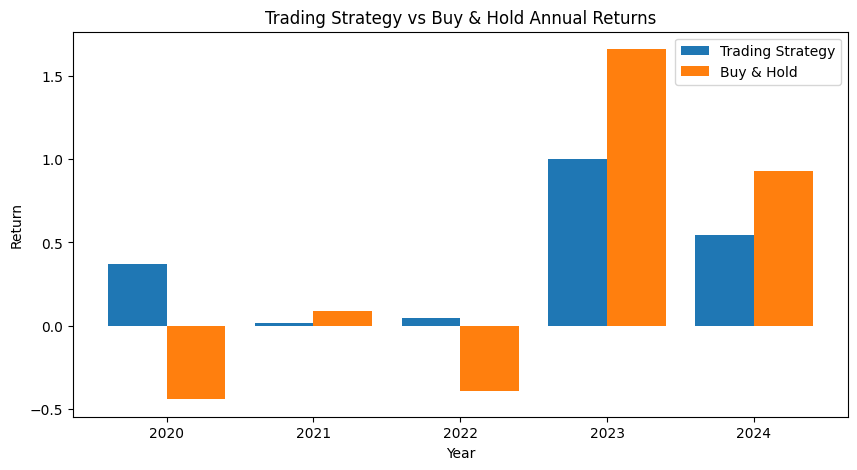

In [25]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import itertools

# Function to calculate Price Volume Trend (PVT)
def calculate_pvt(df):
    pvt = [0]  # Initial PVT value
    for i in range(1, len(df)):
        pvt_value = pvt[-1] + ((df['Close'][i] - df['Close'][i-1]) / df['Close'][i-1]) * df['Volume'][i]
        pvt.append(pvt_value)
    return pd.Series(pvt, index=df.index)

# Function to calculate Fisher Transform and its Signal line
def calculate_fisher_transform(df, period=10):
    high_rolling = df['High'].rolling(window=period).max()
    low_rolling = df['Low'].rolling(window=period).min()

    # Calculate X
    X = 2 * ((df['Close'] - low_rolling) / (high_rolling - low_rolling) - 0.5)

    # Fisher Transform
    fisher = 0.5 * np.log((1 + X) / (1 - X))

    # Signal line (Exponential Moving Average of Fisher)
    fisher_signal = fisher.ewm(span=9).mean()  # Default 9-period EMA

    return fisher, fisher_signal

# Walk-forward optimization with PVT + Fisher Transform
def walk_forward_optimization_pvt_fisher(df, start_year, end_year):
    results = []

    # Define dynamic ranges for Fisher Transform period and PVT shift parameter
    fisher_period_range = range(5, 21)  # Range for Fisher Transform periods
    pvt_shift_range = range(10, 31)  # Range for PVT shift parameter

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1
        test_start = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        # Loop through all combinations of Fisher and PVT parameters
        for fisher_period, pvt_shift in itertools.product(fisher_period_range, pvt_shift_range):
            # Calculate Fisher Transform and Signal line on the training data
            train_data['Fisher'], train_data['Fisher_Signal'] = calculate_fisher_transform(train_data, period=fisher_period)
            train_data['PVT'] = calculate_pvt(train_data)

            # Generate entry and exit signals based on PVT and Fisher Transform
            entries = (train_data['PVT'] > train_data['PVT'].shift(pvt_shift)) & (train_data['Fisher'] > train_data['Fisher_Signal'])
            exits = (train_data['PVT'] < train_data['PVT'].shift(pvt_shift)) & (train_data['Fisher'] < train_data['Fisher_Signal'])

            # Backtest on training data
            portfolio = vbt.Portfolio.from_signals(
                close=train_data['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001
            )

            performance = portfolio.total_return()
            if performance > best_performance:
                best_performance = performance
                best_params = (fisher_period, pvt_shift)

        # Test with the best parameters on the test data
        # Extend the data range to include the previous year for indicator calculation
        yearly_data = df[(df.index.year >= test_year - 1) & (df.index.year <= test_year)]

        # Apply Fisher Transform and PVT
        yearly_data['Fisher'], yearly_data['Fisher_Signal'] = calculate_fisher_transform(yearly_data, best_params[0])
        yearly_data['PVT'] = calculate_pvt(yearly_data)

        # Keep only the second year to avoid missing values from indicator calculation
        yearly_data = yearly_data[yearly_data.index.year == test_year]

        entries = (yearly_data['PVT'] > yearly_data['PVT'].shift(best_params[1])) & (yearly_data['Fisher'] > yearly_data['Fisher_Signal'])
        exits = (yearly_data['PVT'] < yearly_data['PVT'].shift(best_params[1])) & (yearly_data['Fisher'] < yearly_data['Fisher_Signal'])

        portfolio = vbt.Portfolio.from_signals(
            close=yearly_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'RCL' # RCL SYF TPL TPR TRGP
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Perform walk-forward optimization
results = walk_forward_optimization_pvt_fisher(df, 2016, 2025)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Combine signals into a single portfolio
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    params = row['Best_Params']

    # Extend the data range to include the previous year for indicator calculation
    yearly_data = df[(df.index.year >= year - 1) & (df.index.year <= year)]

    # Apply Fisher Transform and PVT
    yearly_data['Fisher'], yearly_data['Fisher_Signal'] = calculate_fisher_transform(yearly_data, params[0])
    yearly_data['PVT'] = calculate_pvt(yearly_data)

    # Keep only the second year to avoid missing values from indicator calculation
    yearly_data = yearly_data[yearly_data.index.year == year]

    # Define entry/exit conditions
    entries = (yearly_data['PVT'] > yearly_data['PVT'].shift(params[1])) & \
              (yearly_data['Fisher'] > yearly_data['Fisher_Signal'])
    exits = (yearly_data['PVT'] < yearly_data['PVT'].shift(params[1])) & \
            (yearly_data['Fisher'] < yearly_data['Fisher_Signal'])

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Filter data for testing period only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

# Backtest using the combined signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

# Get unique years in the dataset
years = sorted(df.index.year.unique())

# Store annual returns
strategy_returns = {}
buy_and_hold_returns = {}

for year in years:
    yearly_data = df[df.index.year == year]

    if not yearly_data.empty:
        # Buy & Hold Return
        start_price = yearly_data.iloc[0]['Close']
        end_price = yearly_data.iloc[-1]['Close']
        buy_and_hold_return = (end_price - start_price) / start_price
        buy_and_hold_returns[year] = buy_and_hold_return

        # Strategy Return
        strategy_returns[year] = results[results['Year'] == year]['Test_Return'].values[0]

# Plot bar chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
plt.bar([y - bar_width/2 for y in strategy_returns.keys()], strategy_returns.values(), width=bar_width, label="Trading Strategy")
plt.bar([y + bar_width/2 for y in buy_and_hold_returns.keys()], buy_and_hold_returns.values(), width=bar_width, label="Buy & Hold")

plt.xlabel("Year")
plt.ylabel("Return")
plt.title("Trading Strategy vs Buy & Hold Annual Returns")
plt.legend()
plt.xticks(list(strategy_returns.keys()))

plt.show()
